# MIE1624 - COVID 19 Final Project

## Import Python Libraries

In [1]:
#Install Libraries - Google Colab Environment

#!pip install numpy
#!pip install pandas
#!pip install sklearn
#!pip install scipy
#!pip install --upgrade pip
#!pip install -U functools32
#!pip install -U spacy
#Download spaCy's  'en' Model
#!{sys.executable} -m spacy download en
#!{sys.executable} -m spacy download en_core_web_sm
#!pip install -U cufflinks

In [2]:
# Install Libraries - Anaconda Environment
#pip install sklearn

In [3]:
#pip install scipy

In [4]:
#pip install --upgrade pip

In [5]:
#pip install spacy

In [6]:
#pip install -U spacy

In [7]:
#pip install fuzzywuzzy

In [8]:
#pip install contractions

In [9]:
#Import Libraries

import csv
import random
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import spacy
#import en_core_web_sm
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import seaborn as sns
from fuzzywuzzy import fuzz 

import unicodedata
nltk.download('wordnet')
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charliewu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1.0 Data Cleaning

In [10]:
df = pd.read_csv('metadata.csv')

In [11]:
# load the meta data from the CSV file and extract out fields that will be useful to our application

df = df[['title','abstract','authors','publish_time']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()

In [12]:
df.head()

,title,abstract,authors,publish_time
0,SIANN: Strain Identification by Alignment to N...,next-generation sequencing is increasingly bei...,Samuel Minot; Stephen D Turner; Krista L Ternu...,2014-01-10
1,Spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,Lin WANG; Xiang Li,2014-06-04
2,Sequencing of the human IG light chain loci fr...,germline variation at immunoglobulin gene (ig)...,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,2014-07-03
3,Bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,Sofia Morfopoulou; Vincent Plagnol,2014-07-25
4,Mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,Stephen P Velsko; Jonathan E Allen,2014-11-11


In [13]:
# Structure analysis
num_words = df['abstract'].apply(lambda x: len(x.split())) # Calcuate the number of words for each article abstrat
num_words_mean, num_words_std = np.mean(num_words), np.std(num_words) # Calculate the mean and std
num_sentences = df['abstract'].apply(lambda x: len(re.split( '~ ...' ,'~'.join(x.split('.')))))
num_sentences_mean = np.mean(num_sentences)
print(num_words_mean, num_words_std, num_sentences_mean)

200.34634382046602 140.81691694664494 8.871308923010846


In [14]:
# combine title and abstract since title might also contain very useful information
df['full_text'] = df["title"].map(str)+ '. ' + df["abstract"]

In [15]:
# strip html tag
def strip_html_tag(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
df['full_text'] = df['full_text'].apply(strip_html_tag)

In [16]:
# remove punctuation
import string
def remove_punctuation(text):
        no_punctuation = "".join([c for c in text if c not in string.punctuation])
        return no_punctuation
df['full_text'] = df['full_text'].apply(remove_punctuation)

In [17]:
# fix contractions
import contractions
df['full_text'] = df['full_text'].apply(contractions.fix)

In [18]:
# an example of fixing contractions
contractions.fix('You don\'t need a library')

'You do not need a library'

In [19]:
# remove special characters
def remove_special_char(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [20]:
# Remove Stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
df['full_text'] = df['full_text'].apply(remove_stopwords)

In [21]:
# further normalization of corpus by applying lower case to all texts and remove special characters
def normalize_corpus(corpus, lower_case=True, stemming=True,
                     text_lemmatization=True, special_char_removal=True, 
                     remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # lowercase the text    
        if lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # stem text
        # doc = stemming(doc)
        # lemmatize text
        #if text_lemmatization:
        #    doc = lemmatize_text(doc)
        # remove special characters   
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_char(doc, remove_digits=remove_digits)  
            
        normalized_corpus.append(doc)
        
    return normalized_corpus
df['clean_text'] = normalize_corpus(df['full_text'])

In [22]:
df.head()

,title,abstract,authors,publish_time,full_text,clean_text
0,SIANN: Strain Identification by Alignment to N...,next-generation sequencing is increasingly bei...,Samuel Minot; Stephen D Turner; Krista L Ternu...,2014-01-10,SIANN Strain Identification Alignment Near Nei...,siann strain identification alignment near nei...
1,Spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,Lin WANG; Xiang Li,2014-06-04,Spatial epidemiology networked metapopulation ...,spatial epidemiology networked metapopulation ...
2,Sequencing of the human IG light chain loci fr...,germline variation at immunoglobulin gene (ig)...,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,2014-07-03,Sequencing human IG light chain loci hydatidif...,sequencing human ig light chain loci hydatidif...
3,Bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,Sofia Morfopoulou; Vincent Plagnol,2014-07-25,Bayesian mixture analysis metagenomic communit...,bayesian mixture analysis metagenomic communit...
4,Mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,Stephen P Velsko; Jonathan E Allen,2014-11-11,Mapping viral phylogeny onto outbreak trees im...,mapping viral phylogeny onto outbreak trees im...


## 2.0 Exploratory Data Analysis - Ways of Transmissions of CONVID-19

### The purpose of the study is to learn about the differents ways of transmissions of CONVID-19 in the papers. By clustering the different transmission methods of the virus, hopefully targeted and corresponding actions can be taken by our healthcare system, government and industries to prevent the spread and fight against CONVID-19.

**After some research online on the CONVID-19 related reports from WHO and governments around the world, a bag of words is created to enable looking into the papers for related insights on the ways of transmissions of CONVID-19.**

In [23]:
# Define a list of ways of transmissions of CONVID-19 from various reports: https://matangitonga.to/2020/03/16/who-covid-15mar (a report from WHO)
transmission = ['touch','surface','object', 'tissue','droplet','contact','nose','mouth','hands']

**What can be observed from the graph below is that out of the proposed 9 keywords related to the ways of transmission of CONVID-19, 3 keywords have appeared for over 2000 times in the corpus. Most of the keywords have got significant appearances in the papers, meaning that the study direction is also of interest to the researchers.**

{'touch': 78, 'surface': 2213, 'object': 2666, 'tissue': 2560, 'droplet': 239, 'contact': 1528, 'nose': 1680, 'mouth': 280, 'hands': 119}


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


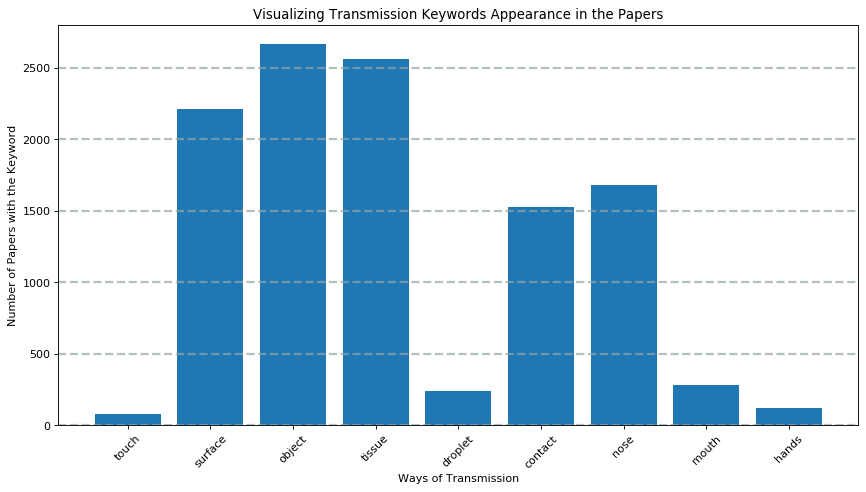

In [24]:
# Visualize number of times each way of transmission appears in all papers
trans_count = dict((trans,0) for trans in transmission)

for trans in trans_count:
    for text in df['clean_text'] :
        if str(trans) in text:
            trans_count[trans] += 1

print(trans_count)

loc = np.arange(len(trans_count))
width = 0.35

fig = plt.figure(num=None, constrained_layout=True, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

ax.bar(trans_count.keys(),trans_count.values())
ax.set_xticks(loc, tuple(trans))

ax.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax.set_ylabel('Number of Papers with the Keyword')
ax.set_xlabel('Ways of Transmission')
ax.set_title('Visualizing Transmission Keywords Appearance in the Papers')
plt.xticks(rotation=45)
plt.show()

**The following graph intends to find out that do the keywords appear in different papers or do some of them appear in the same paper as well. What is learned is that some of the keywords do appear in the same papers. Considering the definition of distance matrix for clustering later, this probably means that some keywords in nature are closer to each other and are possibly considered to be in the same bigger cluster of ways of transmission of CONVID-19.**

In [25]:
# Calculate the number of keywords in each article
for index, row in df.iterrows():
    keyword_count = 0
    for trans in trans_count:
        if str(trans) in row['clean_text']:
            keyword_count += 1
    df.loc[index, 'keyword_count']=keyword_count

Number of Papers Found with ? Keywords 
 0.0    27428
1.0     8447
2.0     1250
3.0      103
4.0       16
5.0        5
6.0        3
Name: keyword_count, dtype: int64


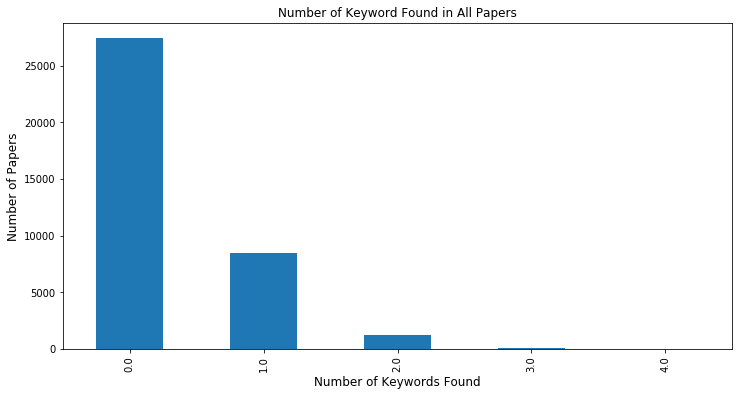

In [26]:
keyword_count  = df['keyword_count'].value_counts()
print("Number of Papers Found with ? Keywords \n",keyword_count)
keyword_count = keyword_count[:5,]
plt.figure(figsize=(12,6))
keyword_count.plot(kind='bar')
# sns.barplot(keyword_count.index, keyword_count.values, alpha=0.6)
plt.title('Number of Keyword Found in All Papers')
plt.ylabel('Number of Papers', fontsize=12)
plt.xlabel('Number of Keywords Found', fontsize=12)
plt.show()

**Many of the papers found to contain keywords related to ways of transmission of CONVID-19 is from 2020, which should be very relevant to CONVID-19 since the outbreak of the virus in many countries started in early 2020. Except for 2020 papers, a few recent papers also contain transmission related keywords, which could be good references to the study since there were a couple of respiratory disease outbreaks in the last 10 years in both Middle East and South America. This also indicates that the interests in studying transmission of these viruses have increased in recent years as without a care, the main way to fight against these viruses is to contain them.**

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


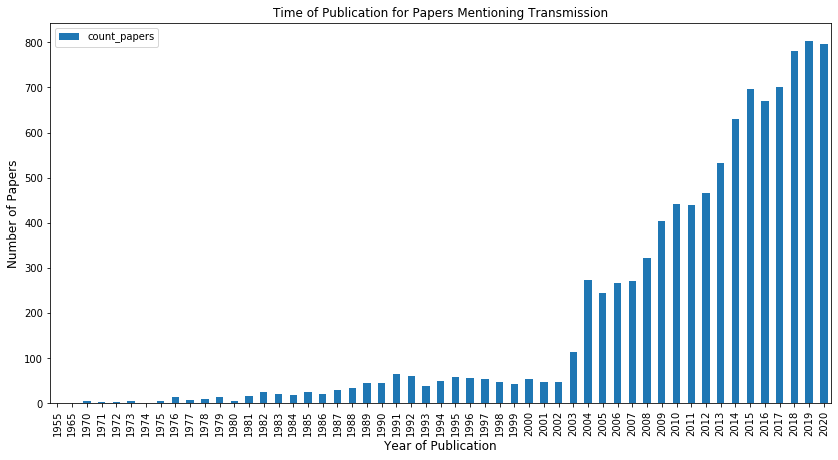

In [27]:
df_with_keywords = df[df['keyword_count']!=0]
df_with_keywords['publish_year']=df_with_keywords['publish_time'].str[:4]
df_plot = df_with_keywords.groupby(['publish_year'])['title'].count().reset_index().rename(columns=\
                                                                                    {'title':'count_papers'})

df_plot.plot.bar(x='publish_year', y='count_papers',figsize=(14,7))
plt.title('Time of Publication for Papers Mentioning Transmission')
plt.ylabel('Number of Papers', fontsize=12)
plt.xlabel('Year of Publication', fontsize=12)
plt.show()

## 3.0 Model Selection and Fitting to Data - Clustering Ways of Transmissions of CONVID-19

### Since the bag of words defined through research online might not cover all ways of transmissions mentioned in the papers, a deep dive into the papers to find out if there are further keywords mentioned related to transmissions is necessary. The purpose of doing this is to cover more keywords related to transmissions thus more types of transmissions, to prepare for our further clustering analysis on the different ways of transmissions.

**Naturally papers containing 'transmit', 'transmission' or 'spread' should be relevant to the study of interest. The plan is to filter for 15 words before and after 'transmit', 'transmission' or 'spread', and by digging deeper into the patterns of words around these 3 keywords, more transmission related keywords might be found.**

In [28]:
keywords = ['transmit','transmission','spread']

In [29]:
# Calculate the number of article that contains each of keywords 
keyword_count = dict((key,0) for key in keywords)

for key in keyword_count:
    for text in df['clean_text'] :
        if str(key) in text:
            keyword_count[key] += 1

print(keyword_count)

{'transmit': 874, 'transmission': 3337, 'spread': 3523}


In [30]:
# Check the number of articles that contain the keywords
df_relevant = df[df['clean_text'].str.contains('|'.join(keywords))]
len(df_relevant)

6276

In [31]:
def window_string(text, keywords=keywords):
    relevant_text=[]
    text=text.split()
    # if keywords mentioned, the following loop loops through each keyword found by Levenshtein
    k=0 
    for p in keywords:
        word=keywords[k]
        for i, w in enumerate(text):
            # for extracting the content near a keyword like 'close contact', use a window of 2 words
            # to loop through the text to find the position of 'close contact'
            v=text[i:i+len(word.split())]
            v=' '.join(word for word in v)
            # check if looping window content is the same as 'close contact'
            if fuzz.ratio(v, word)>80:
                if i-15>0: before_word=text[i-15:i] 
                else: before_word=text[0:i]
                before_word = ' '.join(word for word in before_word)
                if i+15+len(word.split())<len(text):
                    after_word = text[i+len(word.split()):i+15+len(word.split())]
                else: after_word = text[i+len(word.split()):]
                after_word = ' '.join(word for word in after_word)
                # record the content near each keyword found in the text
                relevant_text.append(before_word+ ' <'+v+'> '+after_word)
        k=k+1
    relevant_text = ' '.join(string for string in relevant_text)
    return relevant_text

In [32]:
df_relevant['relevant_text'] = df_relevant['clean_text'].apply(window_string) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
df_relevant = df_relevant[df_relevant['relevant_text']!='']

In [34]:
# The following function is modified from a online source : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) # create a word frequency matrix for the model 
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_relevant['relevant_text'], 100)
# for word, freq in common_words:
#     print(word, freq)
df_top_n_grams = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df_top_n_grams.head(10)

,ReviewText,count
0,respiratory syndrome,671
1,infectious diseases,529
2,public health,511
3,acute respiratory,451
4,infectious disease,437
5,disease transmission,432
6,novel coronavirus,409
7,severe acute,387
8,middle east,328
9,influenza virus,317


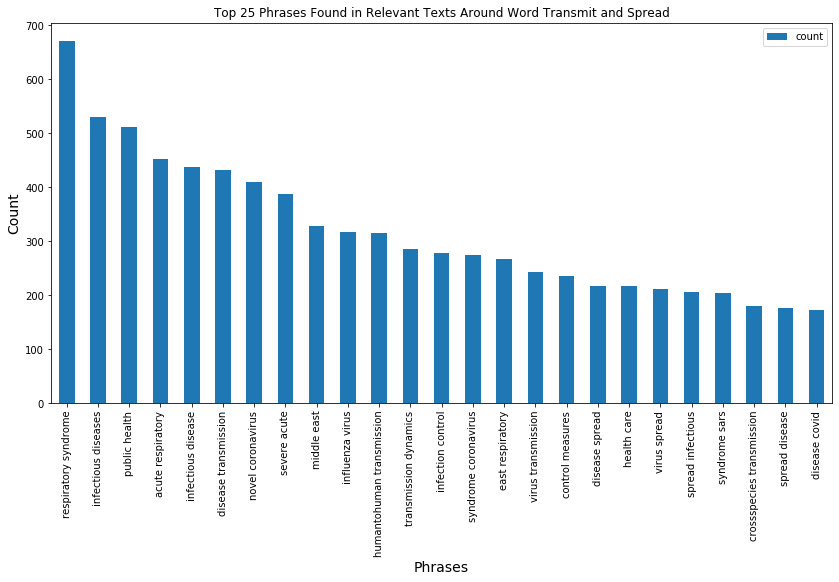

In [35]:
df_plot = df_top_n_grams.head(25)
df_plot.groupby('ReviewText').sum()['count'].reset_index().sort_values(by=['count'],ascending=False)

df_plot.plot.bar(x='ReviewText', y='count',figsize=(14,7))
plt.title('Top 25 Phrases Found in Relevant Texts Around Word Transmit and Spread')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Phrases', fontsize=14)
plt.show()

In [36]:
# Remove some less meaningful words to our topic: e.g., 'public health', 'severe acute', 'middle esat'
word_filter = ['influenza virus','respiratory syndrome','infectious diseases','disease covid',
               'infectious disease','public health','acute respiratory','novel coronavirus','control measures',
               'east respiratory','severe acute','middle east','syndrome coronavirus','health care','infection control']
filtered = dict()
for phrase, count in common_words:
    if str(phrase) not in word_filter:
        filtered [phrase] = count

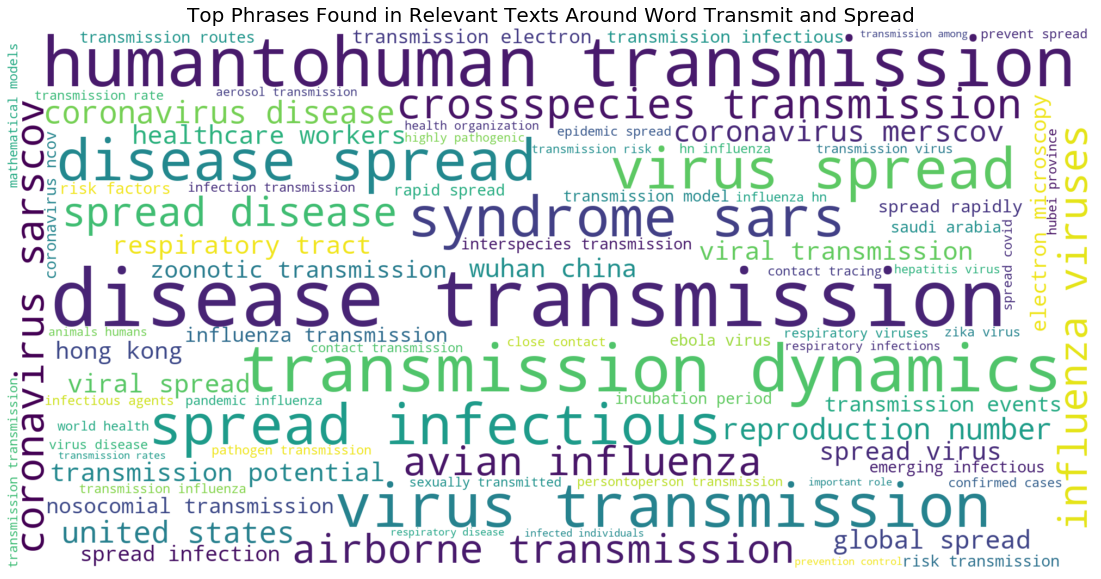

In [37]:
# Generate WorldCloud to visualize the the important and filtered phrases in the relevant texts
from wordcloud import WordCloud

wordCloud = WordCloud(width = 2000, height = 1000,background_color= 'white')
wordCloud.generate_from_frequencies(dict(filtered))
plt.figure(figsize=(20,10))
plt.title('Top Phrases Found in Relevant Texts Around Word Transmit and Spread',fontsize = 20)
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### K-Means Clustering

**In addition to the above text analysis, the text classification with K-means Clustering (unsupervised model) is also performanced. The reason for using this model is because there is no target values and therefore is treated as an unsupervised machine learning problem.
Bascially, K-means would provide me the insight that how texts and phrases related to transimssion are clustered and grouped. This could help me understand, for example, what types of transimmision (e.g., airbone,human to human) would cause people infected by Covid-19. Furthermore, this step is to help me derive some useful insights which will be prepared for fitting the hierarchical clustering.**

In [38]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
def common_words_filtering (text):
    # Remove Stop words
    Stop_word_list = ['influenza','virus','respiratory,','syndrome','infectious','diseases','disease','covid',
               'infectious','public','health','acute','respiratory','novel','coronavirus','severe','middle','east','care','infection','control','spread']
    Stop_Words = set(stopwords+Stop_word_list)
    df_cleaned = " ".join([word for word in text.split() if word not in Stop_Words])
    return df_cleaned

In [40]:
relevant_clean_df =df_relevant['relevant_text'].apply(common_words_filtering)

In [41]:
relevant_clean_df[1]

'transnational spreading sars global outbreak ahn recent potential invasion avian ahn study dynamics mediating <transmission> emerging spatial epidemiology networked metapopulation provides valuable modeling framework takes spatially distributed factors consideration'

In [42]:
# Calcuate the TF-IDF with TfidVectorizer - from NLP_example_assignment2
def TFIDF_processor (df,num):
    
    vectorizer = TfidfVectorizer(max_features=num,ngram_range=(2, 2))
    X_TFIDF = vectorizer.fit_transform(df)
    X_TFIDF_array = vectorizer.fit_transform(df).toarray()
    feature_name = vectorizer.get_feature_names()
    X_TFIDF_df = pd.DataFrame(X_TFIDF_array, columns=feature_name)
    
    return X_TFIDF_df,X_TFIDF,vectorizer

In [43]:
X_tfidf_df,X_TFIDF,vectorizer= TFIDF_processor(relevant_clean_df,100)

In [44]:
X_tfidf_df.head()

,aerosol transmission,air travel,airborne transmission,animals humans,around world,basic reproduction,cases reported,central nervous,close contact,confirmed cases,...,transmitted via,united states,vertical transmission,viral infections,viral spread,viral transmission,west africa,world organization,wuhan china,zoonotic transmission
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# K-menas clustering with 4 clusters
k = 4
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(X_TFIDF)

order_centroids = model.cluster_centers_.argsort()[:, ::-1] # get the centroid
terms = vectorizer.get_feature_names()

In [46]:
for i in range(k):
    print("Cluster:",i +1)
    print('----------------------------')
    for ind in order_centroids[i, :11]:
        print('%s' % terms[ind])
    print('----------------------------')
    print('\n')

Cluster: 1
----------------------------
transmission dynamics
humantohuman transmission
risk transmission
zoonotic transmission
wuhan china
transmission electron
electron microscopy
airborne transmission
prevent spread
hong kong
interspecies transmission
----------------------------


Cluster: 2
----------------------------
crossspecies transmission
host species
transmission events
interspecies transmission
animals humans
transmission viruses
transmission potential
transmitted humans
direct contact
spike protein
zoonotic transmission
----------------------------


Cluster: 3
----------------------------
highly pathogenic
spread rapidly
transmission via
dromedary camels
united states
persontoperson transmission
route transmission
transmission may
viral spread
humantohuman transmission
epidemic diarrhea
----------------------------


Cluster: 4
----------------------------
viral spread
central nervous
nervous system
viral infections
results suggest
important role
persontoperson transmiss

**After digging deep into the transmission related keywords found in the top 30 phrases from the relevant texts ('transmit', 'transmission' and 'spread') and the classified groups from k-means clustering, 4 new keywords are added to the bag of words.**

In [47]:
new_transmission = ['humantohuman','crossspecies','airborne','nosocomial']
transmission.extend(new_transmission) 
len(transmission)

13

**In order to cluster these keywords, a distance matrix is created. The distance between two keywords is calculated by summarizing how many times they appear in the same paper together, how many times they don't appear in the same paper.**

In [48]:
#Define the metric that will be used to define the "distance" metric used in the heirarchical clustering algorithm
transmission_list = np.zeros((len(transmission),len(transmission)), dtype=float)

df_transmissions = pd.DataFrame(transmission_list, columns=transmission, index=transmission)
df_transmissions

,touch,surface,object,tissue,droplet,contact,nose,mouth,hands,humantohuman,crossspecies,airborne,nosocomial
touch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
surface,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
object,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tissue,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
droplet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
contact,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nose,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mouth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
humantohuman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
#Helper function that will calculate the distance

def cumulative_dist(trans1, trans2, df):
    cum_sum = 0
    number_of_papers = 0
    if trans1 == trans2: return 0
    
    for abstract in df['clean_text']:
        if ((trans1 in abstract) and (trans2 in abstract)):
            number_of_papers += 1
            cum_sum -= 1
        elif (((trans1 in abstract) and (trans2 not in abstract)) or ((trans1 not in abstract) and (trans2 in abstract))):
            number_of_papers += 1
            cum_sum += 1
    
    return cum_sum/number_of_papers


#Populate Matrix of symptom distances by mining the text of the papers found in the database and using the distance rule as

#For a symptom A and B mentioned in a paper together the distanceA_B += 1 
# or distanceA_B -= 1 if they are not mentioned together

transmission_dist = np.zeros((len(transmission),len(transmission)),float)
#print(symptom_dist)
#print()
for i in range(len(transmission)):
    for j in range(len(transmission)):
         transmission_dist[i][j] = cumulative_dist(transmission[i],transmission[j], df)               

In [50]:
i = 0
for trans in transmission:
    df_transmissions[trans] = np.power(transmission_dist[i],14)
    i += 1
print('Our distance matrix looks like this:')   
df_transmissions

Our distance matrix looks like this:


,touch,surface,object,tissue,droplet,contact,nose,mouth,hands,humantohuman,crossspecies,airborne,nosocomial
touch,0.000000,0.741107,0.893014,0.968589,0.763299,0.649627,0.908264,0.668762,0.552843,0.646726,1.000000,0.803976,0.873197
surface,0.741107,0.000000,0.685774,0.225965,0.662690,0.423950,0.593149,0.852972,0.823011,0.878516,0.805856,0.625149,0.827752
object,0.893014,0.685774,0.000000,0.531045,0.782556,0.292888,0.187241,0.840971,0.790470,0.914947,0.980338,0.706970,0.668560
tissue,0.968589,0.225965,0.531045,0.000000,0.868084,0.613139,0.441311,0.827069,0.979283,0.893126,0.892040,0.879981,0.881000
droplet,0.763299,0.662690,0.782556,0.868084,0.000000,0.184743,0.850132,0.538042,0.436641,0.402395,0.867192,0.019957,0.490230
contact,0.649627,0.423950,0.292888,0.613139,0.184743,0.000000,0.345922,0.639207,0.633518,0.412466,0.711603,0.410673,0.375613
nose,0.908264,0.593149,0.187241,0.441311,0.850132,0.345922,0.000000,0.682785,0.881940,0.846251,0.843998,0.831058,0.613850
mouth,0.668762,0.852972,0.840971,0.827069,0.538042,0.639207,0.682785,0.000000,0.697734,0.941562,1.000000,0.613420,0.912965
hands,0.552843,0.823011,0.790470,0.979283,0.436641,0.633518,0.881940,0.697734,0.000000,0.755777,1.000000,0.670302,0.643085
humantohuman,0.646726,0.878516,0.914947,0.893126,0.402395,0.412466,0.846251,0.941562,0.755777,0.000000,0.780521,0.751470,0.482795


**Hierarchical Clustering is then performed using the defined distance matrix. The best number of clusters is relatively hard to tell from the dendrogram of the clustering results, probably due to the different word utilization habits of different authors and thus the limitation of the definition of the distance matrix. However, useful insights can be derived to help government, health system and other entities to fight against CONVID-19.**

In [51]:
distance = np.power(transmission_dist,14)  #Magnify the distance prior to HCA
#distance

Y = sch.linkage(distance, method='centroid')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Dendrogram Displaying COVID-19 Ways of Tranmission Clusters')

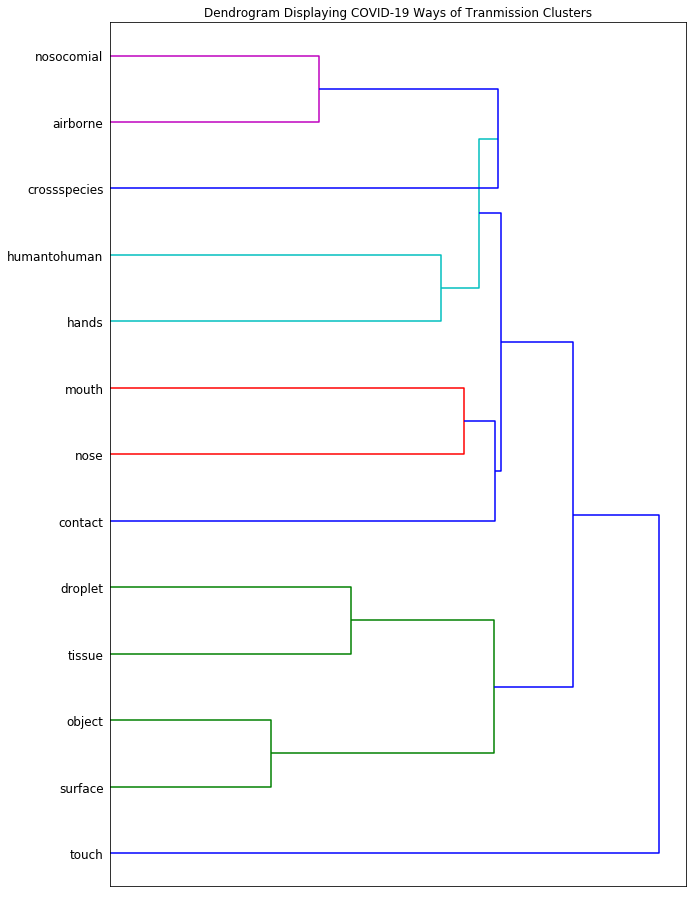

In [52]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get dendrograms
Z1 = sch.dendrogram(Y, orientation='right')

ax1.set_xticks([])
ax1.set_yticklabels(transmission)
ax1.set_title("Dendrogram Displaying COVID-19 Ways of Tranmission Clusters")

## 4.0 Derive Insights About Policy and Guidance

### From the hierarchical clustering (clustering of the ways of transmission of CONVID-19), some useful insights can be derived as folllows. In order not to provide too much information as well as not to lose too much information, 4 clusters of ways of transmission are discussed for recommendations on Policy and Guidance: 

- Cluster 1 Keywords: Droplet, Tissue, Object, Surface, Touch
- Cluster 2 Keywords: Mouth, Nose, Contact, Humantohuman, Hands
- Cluster 3 Keywords: Crossspecies
- Cluster 4 Keywords: Nosocomial, Airborne

- Cluster 1 way of transmission is focused on the objects that can pass the disease to a healthy person if an infected person has touched/used it. Such transmission media could be any object or surface in public places such as hand rails, elevator buttons or any tissue, towels that have been used/consumed by the infected person.
### To cope with this way of transmission, governments need to organize regular routines to clean and disinfect public places, such as railway station, building lobbies and etc. Industries need to ensure the supply of hygiene products such as alcohol rubs, masks. Companies that run places such as shopping malls, grocery stores need to offer proper hygiene at the entrance and ensure regular routines to clean and disinfect as well.

- Cluster 2 way of transmission is focused on person to person contact. Since CONVID-19 can have a long incubation period, some of the people who are infected won't show any symptoms. If a healthy person shakes hands with an infected person, or even if the healthy person has met an infected person for one time and has touched something that the infected person had touched, he/she can catch the disease.
### To prevent the second way of transmission. Governments need to ask people to perform social distancing and enforce people who had contacts with anyone infected to perform self-quanrantine. Doctors and Nurses need to wear masks, protective suits and gloves when treating infected patientes. Scientists can study how to reduce the risk of public health by temporarily closing down some businesses and reducing crowds in public places.

- Cluster 3 is focused on crossspecies transmission. Animals can pass viruses to human beings. Vice versa, human beings can also pass viruses to animals.
### To prevent the way of virus transmission, governments need to enforce people not to eat wild animals because they might carry with them diseases. Healthcare professionals need to take control of possible risks posed by stray cats and dogs if they caught the virus from humans and could continue to pass it off to other humans.

- Cluster 4 is focused on transmission in hospitals. Doctors and Nurses are people with the highest risks of catching the disease. And it can be very destructive to the healthcare system if we are losing doctors and nurses with increases in the number of patients.
### To greatly reduce the risks for nosocomial transmissions, governments need to make sure that the hospitals and healthcare professionals have enough PPE. Industries should prioritize the needs from the healthcare system. And doctors and nurses need to performance good hygiene practices. 